This scrip reproduces some of the results from Stoll et al. 2015, on our data.

Variables to be decoded:
    1. Feedback
        - reward
    2. Performance measures
        - action value
        - (reward rate)
        - (target value)
    3. Decision
        - action (selected target)
        - action (switch or stay)
        - phase

In [19]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")

import pandas as pd

from popy.io_tools import *
from popy.behavior_data_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
from popy.decoders import *
from popy.plotting_tools import *


def run_decoder_method(neural_data, session_data, mode, variables_to_decode, areas_to_decode, window_len, step_len, start_on, end_on):
    # df to store results
    all_scores = pd.DataFrame(columns=variables_to_decode, # ['feedback', 'value_function']'value_function', 'RPE', 'switch',  # , 'phase', 'target_1', 'target_2', "target_3"
                            index=areas_to_decode)#, 'both'

    # add new column for rpe

    for target_name in variables_to_decode:
        for area in areas_to_decode:
            print(f"Decoding {target_name} in {area} area")
            all_scores[target_name][area] = linear_decoding(neural_data, session_data, target_name, mode=mode, area=area,
                                                            starts_on=start_on, ends_on=end_on,
                                                            window_len=window_len, step_len=step_len, return_p_values=True)
            
    return all_scores

def plot_across_decoder_results(all_scores_across, variable_to_plot, n_trials=2):
    cm = 1/2.54  # centimeters in inches
    fig, axs = plt.subplots(1, 2, figsize=(2*15*cm, 14*cm))
    # default font size
    plt.rcParams.update({'font.size': 12})

    cmaps = {'MCC': 'Greys', 'LPFC': 'Blues', 'both': 'Greens'}
    thresholds = {'feedback': [0.55, .9],
                'value_function': [0, .7],
                'switch': [0.4, 1],
                'phase': [0.4, 1],
                'target': [.3, .7],
                'RPE': [0, .9]}

    t_max = 7.5
    #time_vector = np.arange(0, t_max * n_trials -window_len, step_len)

    for j, area in enumerate(['MCC', 'LPFC']):
        ax = axs[j]
        data = all_scores_across[variable_to_plot][area]
        #axs[i].plot(time_vector, data, label=area, color=colors[area], linewidth=2)
        im = ax.imshow(data, 
                    vmin=thresholds[variable_to_plot][0] if variable_to_plot in thresholds else None,    
                    vmax=thresholds[variable_to_plot][1] if variable_to_plot in thresholds else None,   
                    origin='lower', cmap=cmaps[area], 
                    extent=[0, t_max * n_trials - window_len, 0, t_max * n_trials - window_len])
        # plot epoch times
        for label, time in ep_times.items():
            for i in range(n_trials):
                ax.axvline(time+i*t_max, color='grey' if label != 'fb' else 'tab:red', linestyle='dashed', alpha=.5, linewidth=1)
                ax.axhline(time+i*t_max, color='grey' if label != 'fb' else 'tab:red', linestyle='dashed', alpha=.5, linewidth=1)
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

                
        # set xticks as epoch labels
        times_ticks = [time + i*7.5 for i in range(n_trials) for time in list(ep_times.values())[:-1]]
        labels_ticks = [label for i in range(n_trials) for label in list(ep_times.keys())[:-1]]
        ax.set_xticks(times_ticks)
        ax.set_xticklabels(labels_ticks, fontsize=8, rotation=90)
        ax.set_yticks(times_ticks)
        ax.set_yticklabels(labels_ticks, fontsize=8)

        ax.set_title(f"{area}")

        # remve top and right spines
        sns.despine()
        # remove legend frame
        ax.legend(frameon=False, loc='upper right')

        ax.set_ylabel('time of fit')
        ax.set_xlabel('time of test')
    plt.suptitle(variable_to_plot, fontsize=16)
    plt.show()



# Get data

In [20]:
monkey, session = 'ka', '150720'

Get behavior

In [21]:
session_data = get_behavior(monkey, session)

# add fb-1, fb-2, ...
"""session_data['fb_m1'] = session_data['feedback'].shift(1)
session_data['fb_m2'] = session_data['feedback'].shift(2)
session_data['fb_m3'] = session_data['feedback'].shift(3)
session_data['fb_m4'] = session_data['feedback'].shift(4)"""
'''
def create_binary(list):
    x = 0
    for he, digit in enumerate(list[::-1]):
        x += digit * 2**he
    return x

n_binary = 3
fb_sequence = np.array([np.nan, np.nan] + [create_binary(session_data.feedback[i:i+n_binary])
               for i in range(len(session_data.feedback)-n_binary+1)])
session_data['fb_sequence'] = fb_sequence'''

# add necessary behav. variables
#session_data = add_phase_info(session_data, exploration_limit=1, transition_limit=6)  # add double feedback label
session_data = add_value_function(session_data)  # add action value
#session_data = add_switch_info(session_data)  # add switch info
session_data = add_RPE(session_data, scale_RPE=False)  # add reward prediction error
# abs RPE
session_data['RPE'] = np.abs(session_data['RPE'])

adding history of feedback column, but if the data is pooled across sessions, make sure to add the history before pooling data to keep the order of time!


C:\ZSOMBI\OneDrive\PoPy\popy\behavior_data_tools.py:187: RuntimeWarning: invalid value encountered in cast
  X = X.astype(int)


In [22]:
'''# plot distributions of RPE
fig, axs = plt.subplots(figsize=(15, 14))
sns.histplot(session_data.RPE)
plt.show()'''

'# plot distributions of RPE\nfig, axs = plt.subplots(figsize=(15, 14))\nsns.histplot(session_data.RPE)\nplt.show()'

In [23]:
# clean up data
session_data = drop_time_fields(session_data)  # remove time fields
session_data = session_data.drop(['block_id', 'best_target'], axis=1)  # drop block_id and best_target

session_data

,trial_id,target,feedback,history_of_feedback,value_function,RPE
0,0,2,False,"[nan, nan, nan, nan, nan, nan, nan, nan]",-2.147484e+09,2.147484e+09
1,1,2,True,"[0.0, nan, nan, nan, nan, nan, nan, nan]",-1.347436e+09,1.347436e+09
2,2,2,False,"[1.0, 0.0, nan, nan, nan, nan, nan, nan]",-8.373027e+08,8.373027e+08
3,3,2,False,"[0.0, 1.0, 0.0, nan, nan, nan, nan, nan]",-5.120275e+08,5.120275e+08
4,4,3,False,"[0.0, 0.0, 1.0, 0.0, nan, nan, nan, nan]",-3.046228e+08,3.046228e+08
...,...,...,...,...,...,...
461,461,2,False,"[True, True, True, False, True, True, True, True]",9.034197e-01,9.034197e-01
462,462,2,True,"[False, True, True, True, False, True, True, T...",5.658663e-01,4.341337e-01
463,463,2,True,"[True, False, True, True, True, False, True, T...",7.231842e-01,2.768158e-01
464,464,2,True,"[True, True, False, True, True, True, False, T...",8.234944e-01,1.765056e-01


In [24]:
# take only one feedback
'''fb_of_interest = False
session_data = session_data[session_data.feedback == fb_of_interest]'''

'fb_of_interest = False\nsession_data = session_data[session_data.feedback == fb_of_interest]'

Get neural data

In [25]:
import popy.config as cfg

# Load neural data
out_path = os.path.join(cfg.PROJECT_PATH_LOCAL, 'data', 'processed', 'rates')
floc = os.path.join(out_path, f'neural_data_{monkey}_{session}.nc')

save = False
load = True

if load:
    neural_data = xr.open_dataarray(floc)
else:
    neural_data = get_neural_data(monkey, session, 'rates', sr=100)

    # remove trunctuated units
    neural_data = remove_trunctuated_neurons(neural_data, delay_limit=10)

    # remove low_firing units
    neural_data = remove_low_fr_neurons(neural_data, 1)
    
    # z-score neural data
    neural_data = scale_neural_data(neural_data)

    # normalize neural data in time
    neural_data = time_normalize_session(neural_data)

if save:
    neural_data.to_netcdf(floc)
    

## Format data for decoding

In [26]:
## Value function

# in order to decode Q_t+1, we need to shift the value_function column by 1
#session_data['value_function'] = session_data['value_function'].shift(-1)
"""session_data['switch'] = session_data['switch'].shift(-1)
session_data['target'] = session_data['target'].shift(-1)
session_data['fb_sequence'] = session_data['fb_sequence'].shift(+1)
"""
#session_data['phase'] = session_data['phase'].shift(-1)

session_data = session_data.dropna()
'''
session_data['fb_m1'] = session_data['fb_m1'].astype('bool')
session_data['fb_m2'] = session_data['fb_m2'].astype('bool')
session_data['fb_m3'] = session_data['fb_m3'].astype('bool')
session_data['fb_m4'] = session_data['fb_m4'].astype('bool')
#session_data['switch'] = session_data['switch'].astype('bool')
session_data.head(10)'''

## Phase
# make it binary: search or repeat only, drop transition (in fact change it to nan)
#session_data.loc[session_data.phase == 'transition', 'phase'] = np.nan

# make target binary
#session_data['target_1'] = session_data['target'] == 1
#session_data['target_2'] = session_data['target'] == 2
#session_data['target_3'] = session_data['target'] == 3

session_data.head(10)

,trial_id,target,feedback,history_of_feedback,value_function,RPE
0,0,2,False,"[nan, nan, nan, nan, nan, nan, nan, nan]",-2.147484e+09,2.147484e+09
1,1,2,True,"[0.0, nan, nan, nan, nan, nan, nan, nan]",-1.347436e+09,1.347436e+09
2,2,2,False,"[1.0, 0.0, nan, nan, nan, nan, nan, nan]",-8.373027e+08,8.373027e+08
3,3,2,False,"[0.0, 1.0, 0.0, nan, nan, nan, nan, nan]",-5.120275e+08,5.120275e+08
4,4,3,False,"[0.0, 0.0, 1.0, 0.0, nan, nan, nan, nan]",-3.046228e+08,3.046228e+08
5,5,2,False,"[0.0, 0.0, 0.0, 1.0, 0.0, nan, nan, nan]",-1.723758e+08,1.723758e+08
6,6,1,True,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, nan, nan]",-8.805138e+07,8.805139e+07
7,7,1,True,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, nan]",-3.428375e+07,3.428375e+07
8,8,1,False,"[True, True, False, False, False, False, True,...",6.351381e-01,6.351381e-01
9,9,1,True,"[False, True, True, False, False, False, False...",4.049819e-01,5.950181e-01


# Correlation btwn variables -- pu it to behavioral analysis

In [27]:
"""# cross-correlation between vars
cols = session_data.columns

# drop nans
df = session_data[cols].dropna()
# switch to binary
#df['switch'] = df['switch'].astype(int)
print(df)

# compute cross-correlation
corr = df.corr()
print(corr)
# round to 2 decimals
corr = corr.round(2)

# plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
# flip x axis 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.set_title('Cross-correlation between variables')
plt.suptitle(f'session: {monkey}{session}')
"""

"# cross-correlation between vars\ncols = session_data.columns\n\n# drop nans\ndf = session_data[cols].dropna()\n# switch to binary\n#df['switch'] = df['switch'].astype(int)\nprint(df)\n\n# compute cross-correlation\ncorr = df.corr()\nprint(corr)\n# round to 2 decimals\ncorr = corr.round(2)\n\n# plot\nfig, ax = plt.subplots(figsize=(5, 5))\nsns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', vmin=-1, vmax=1)\n# flip x axis 90 degrees\nax.set_xticklabels(ax.get_xticklabels(), rotation=45)\n\nax.set_title('Cross-correlation between variables')\nplt.suptitle(f'session: {monkey}{session}')\n"

# Conclusion 1: different cognitive context has different corresponding dynamics


## Time-resolved decoder

In [30]:
variables_to_decode = ['feedback']
areas_to_decode = ['MCC', 'LPFC']

# set parameters for decoding
window_len, step_len = .2, .2
start_on, end_on = 'trial_start', 'trial_end'

mode = 'time_resolved'

"""neural_data_diff = neural_data.diff('time')
neural_data_diff.attrs = neural_data.attrs"""

# run decoder
all_scores = run_decoder_method(neural_data, session_data, mode, variables_to_decode, areas_to_decode, window_len, step_len, start_on, end_on)
#all_scores_across['meta'] = [monkey, session]
all_scores

Decoding feedback in MCC area


100%|██████████| 720/720 [00:05<00:00, 131.55it/s]


Decoding feedback in LPFC area


100%|██████████| 720/720 [00:03<00:00, 235.81it/s]


,feedback
MCC,"([0.5287209302325582, 0.5087209302325582, 0.51..."
LPFC,"([0.49255813953488364, 0.5161627906976743, 0.4..."


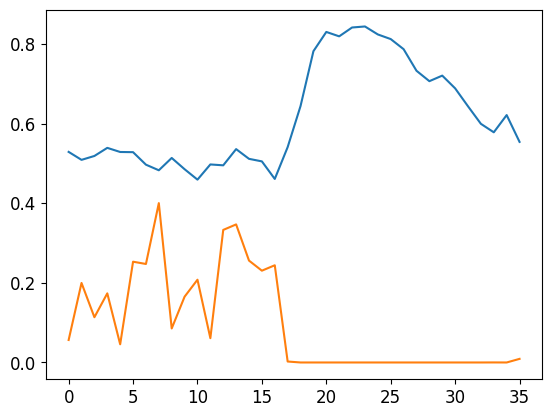

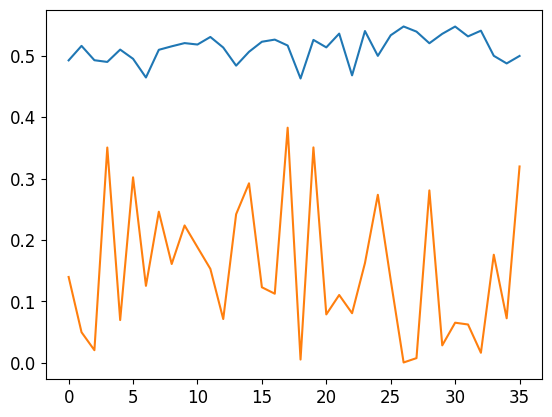

In [54]:
# plot
for i, row in all_scores.iterrows():
    fig, ax = plt.subplots()
    ax.plot(row.feedback[0])
    ax.plot(row.feedback[1])



#### Plotting fo poster

ValueError: x and y must have same first dimension, but have shapes (74,) and (2, 36)

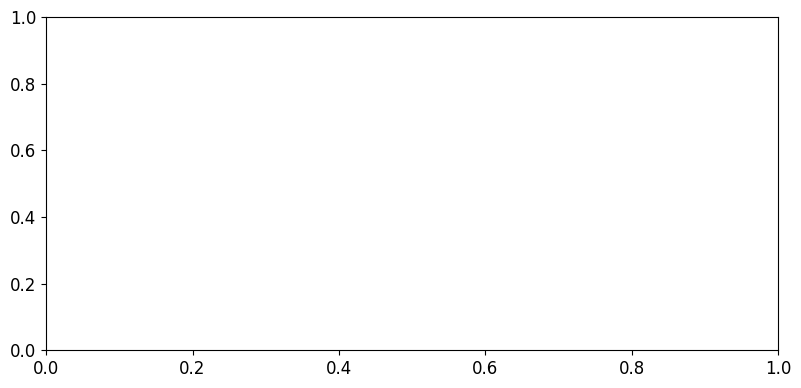

In [32]:
from decoder_tools import *

ep_times = get_epoch_lens(neural_data)

for variable_to_plot in variables_to_decode:   
    all_scores_temp = all_scores[variable_to_plot] 
    plot_decoder_result(all_scores_temp, ep_times, window_len, step_len, start_on, end_on, n_trials=2)


In [ ]:
#plot_stoll(all_scores, neural_data, window_len, step_len, n_trials=1)

## Across-time decoding

In [ ]:
# set parameters for decoding
window_len, step_len = .2, .2

mode='across_time'
all_scores_across = run_decoder_method(neural_data, session_data, mode, variables_to_decode, areas_to_decode, window_len, step_len, start_on, end_on)
all_scores_across['meta'] = [monkey, session]

Decoding value_function in MCC area


100%|██████████| 1480/1480 [00:16<00:00, 88.71it/s]


Decoding value_function in LPFC area


100%|██████████| 1480/1480 [00:06<00:00, 214.04it/s]


In [ ]:
for variable_to_plot in variables_to_decode:    
    plot_decoder_result(all_scores, variable_to_plot, ep_times, window_len, step_len, start_on, end_on, n_trials=2)

TypeError: plot_decoder_result() got multiple values for argument 'n_trials'

In [ ]:
#plot_stoll(all_scores_across, neural_data, window_len, step_len, mode=None, show=True, save=False, savedir=None)